## Import fundamental libraries

In [53]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

random.seed(42)

## Define random function

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

### Evaluate function and plot result over a range of points

In [ ]:
f(3.0)

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

### Apply Fundamental Definition of Differentiation based on Limits

In [ ]:
h = 0.0001
x = 2/3
dfdx = (f(x+h) - f(x-h))/(2*h)
dfdx

## Getting more complex

### Define random variable

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

### Hand-calculate derivative again

In [ ]:
# Nudge
h = 0.001

# inputs
a = 2.0
b = -3.0
c = 10.0


# evaluations
d1 = a*b + c
c += h  # push a forward
d2 = a*b + c  # calculate new d based on new a

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1)/h)

## Define Value object

Value will be used as a data structure to store the massive expressions we expect to encounter when building out neural networks.

In [283]:
class Value:
    """ stores a single scalar value and its gradient """
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)  # store parents. _children is a tuple of Value objects
        self._op = _op
        self._backward = lambda: None  # placeholder for backward function. Nothing to do for leaf nodes
        self.label = label
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():  # gradient function for the sum operation
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():  # gradient function for the mul operation
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self*other**-1  # a/b = a * b**-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad  # chain rule: d(exp(x))/dx = exp(x)
        
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1  # unary negation
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be an int or float"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other  # swap order of the operands
    
    def __rsub__(self, other):
        return -self + other
    
    def __rmul__(self, other):
        return self * other  # swap order of the operands
        
    def tanh(self):  # activation function
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()
        

In [74]:
Value(2.0) / 4

Value(data=0.5)

### Test basic operations

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = a + b
d = a.__add__(b)  #  same as c = a + b
print(c, d)

e = a * b
f = a.__mul__(b)  # same as e = a * b
print(e, f)

g = a + b * c
h = a.__add__(b.__mul__(c))  # same as g = a + b * c
print(g, h)

### Set up forward pass

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
# d = a * b + c
print(L)
print(L._prev)  # check parents
print(L._op)
print(L.grad)

## Define functionality to visualise graph

In [256]:
from graphviz import Digraph

In [257]:
def trace(root):
    # builds a set of all nodes and edges in the graph recursively
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)  # get all nodes and edges
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        uid = str(id(n))  # unique id for each node
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if the node has an operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # print(n1, n2)
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [ ]:
draw_dot(L)

## Play with backprop

In [ ]:
def set_manual_gradients():
    L.grad = 1.0
    f.grad = 4
    d.grad = -2

    dLdd = d.grad
    dddc = (((d+c).data+0.001) - (d+c).data)/(0.001)

    # Due to same reasons:
    ddde = dddc

    dLdc = dLdd * dddc  # chain rule
    dLde = dLdd * ddde  # chain rule
    d.grad = dLdd
    c.grad = dLdc
    e.grad = dLde

    # Apply chain rule to get gradients of a and b
    deda = b.data  # due to simple multiplication
    dedb = a.data
    dLda = dLde * deda  # chain rule
    dLdb = dLde * dedb  # chain rule

    a.grad = dLda
    b.grad = dLdb

set_manual_gradients()
draw_dot(L)  # redraw with gradients

### Numerical verification of backprop results

In [ ]:
def numerical_grad():
    delta = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += delta
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data
 
    print((L2 - L1)/delta)
numerical_grad()

### Play with obtained gradient values

In [ ]:
def forward(a, b, c, f):
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    L = d * f; L.label = 'L'
    
    return a, b, c, d, e, f, L

In [ ]:
sign = lambda x: math.copysign(1, x)

# Set initial values
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')

# Forward pass
a, b, c, d, e, f, L = forward(a, b, c, f)
print(L)

# Set manual gradients
set_manual_gradients()

# Make a small step in the direction of the gradient (sign of a.grad)
# try to make the value of L go up by changing the value of each of the leaf nodes
a.data += 0.01 * sign(a.grad) 
# b.data += 0.01 * b.grad
# c.data += 0.01 * c.grad
# f.data += 0.01 * f.grad

# Forward pass again
a, b, c, d, e, f, L = forward(a, b, c, f)
print(L)

## Backprop through neuron

![title](../neuron_model.jpeg)

### Plot activation function: tanh

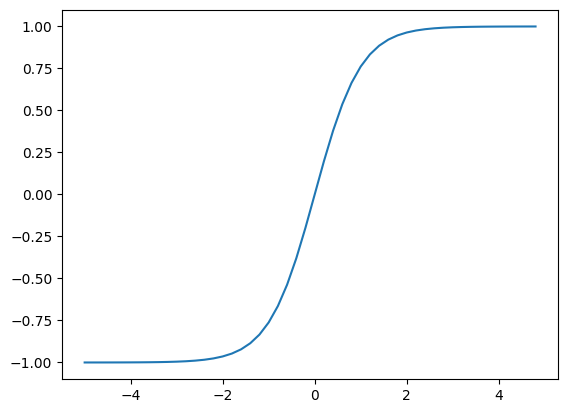

In [258]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)), label='tanh')
plt.show()
# plt.plot(np.arange(-5, 5, 0.2), np.sigmoid(np.arange(-5, 5, 0.2)), label='relu')

### Linear operations in a neuron

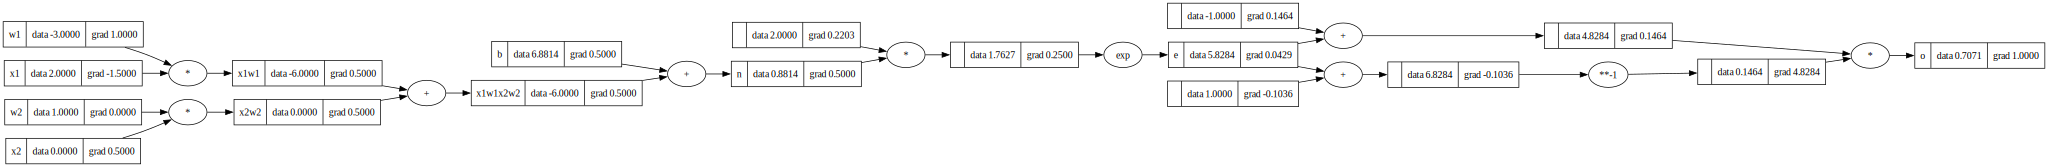

In [284]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# forward pass: dot product of inputs and weights + bias
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2' # sum of products
n = x1w1x2w2 + b; n.label = 'n'  # add bias

# activation function defined with tanh or exp
# o = n.tanh()
e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(e + 1); o.label = 'o'

o.backward()
draw_dot(o)


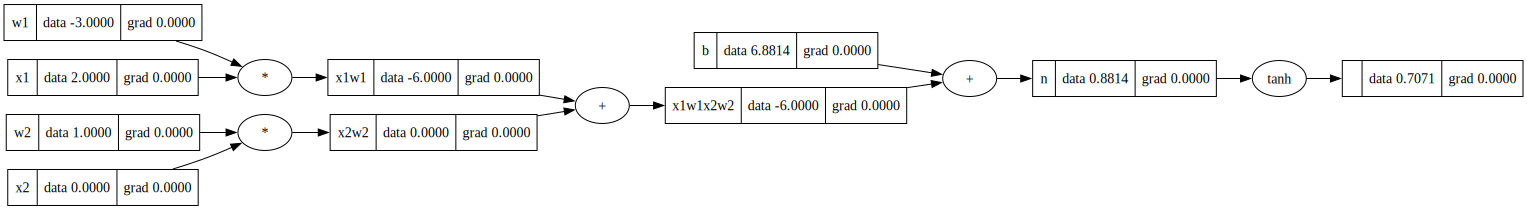

In [ ]:
# draw_dot(o)  # draw the graph

In [ ]:
o.grad = 1.0  # do/do = 1

## backpropagation
# do/dn = 1 - o.data**2  # derivative of tanh
n.grad = (1 - o.data**2)

# do/db = 1.0 * n.grad  # chain rule
# do/dx1w1x2w2 = 1.0 * n.grad  # chain rule
b.grad = n.grad
x1w1x2w2.grad = n.grad

# do/dx1w1 = 1.0 * n.grad
# do/dx2w2 = 1.0 * n.grad
x1w1.grad = n.grad
x2w2.grad = n.grad

# do/dx1 = w1 * n.grad due to chain rule
x1.grad = w1.data * x1w1.grad
# do/dw1 = x1 * n.grad due to chain rule
w1.grad = x1.data * x1w1.grad

# do/dx2 = w2 * n.grad due to chain rule
x2.grad = w2.data * x2w2.grad
# do/dw2 = x2 * n.grad due to chain rule
w2.grad = x2.data * x2w2.grad

## Setting up Autograd

### Topological Sort

In [ ]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        # recursively visit all children
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

In [ ]:
for node in reversed(topo):
    node._backward()
    print(node.label, node.grad)
    
draw_dot(o)

## Call backward function from the end node

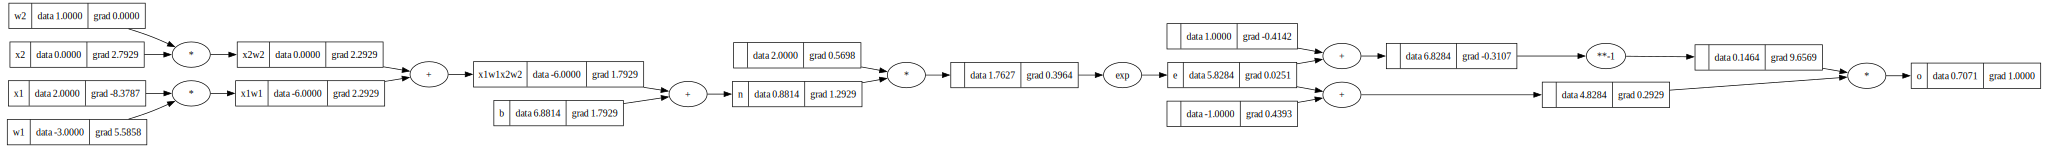

In [282]:
o.backward()
draw_dot(o)

### Accounting for edge case: reused nodes

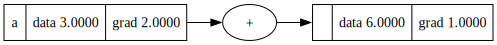

In [ ]:
a = Value(3.0, label='a')
b = a + a; label = 'b'
b.backward()
draw_dot(b)

# note that the gradient (db/da) is 2.0 due to repeated use of a. Done by accumulating the gradient in the _backward functions.

## Analogue with PyTorch

In [ ]:
import torchß

In [2]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True # need to explicitly set requires_grad=True as it is just a "leaf" node otherwise
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----")
print("x1: ", x1.grad.item())
print("x2: ", x2.grad.item())
print("w1: ", w1.grad.item())
print("w2: ", w2.grad.item())

0.7071066904050358
----
x1:  -1.5000003851533106
x2:  0.5000001283844369
w1:  1.0000002567688737
w2:  0.0


## Implement a Neuron and Layer class

In [104]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  # dim of w: (nin, ). nin here is the number of input features. Irrespective of batch size
        self.b = Value(random.uniform(-1, 1))  # dim of b: (1, )
        
    def __call__(self, x):
        # forward pass: weights * inputs + bias
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)  # equivalent to (1 x nin) x (nin x 1) + (1 x 1)
        out = act.tanh()  # apply non-linear activation function
        return out
    
    def parameters(self):
        # return all parameters of the neuron
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]  # nout is the number of output streams from the layer. Each neuron has nin inputs.
                        
    def __call__(self, x):
        # forward pass: call each neuron
        outs = [n(x) for n in self.neurons]  # each neuron takes the same input x. Output is a list of Value objects from each neuron, aggregated
        return outs[0] if len(outs) == 1 else outs  # if only one neuron, return the single output. Otherwise, return a list of outputs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]  # return all parameters of the layer
    

In [69]:
x = [2.0, 3.0, 4.0]
n = Neuron(3)
n(x)  # this invokes __call__ method

l = Layer(3, 4)
l(x)

[Value(data=0.9996598653178975),
 Value(data=-0.9999218527044977),
 Value(data=0.8188750542356685),
 Value(data=-0.9999838404898479)]

## Implement a Multi-Layer Perceptron

In [105]:
class MLP():
    def __init__(self, nin, nouts):
        sz = [nin] + nouts  # list of sizes for each layer. Concatenate the input size and output sizes
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)  # pass the output of one layer to the next
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

### Implement nin=3, nouts=[4, 4, 1]

In [51]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)


Value(data=-0.8795605377375814)

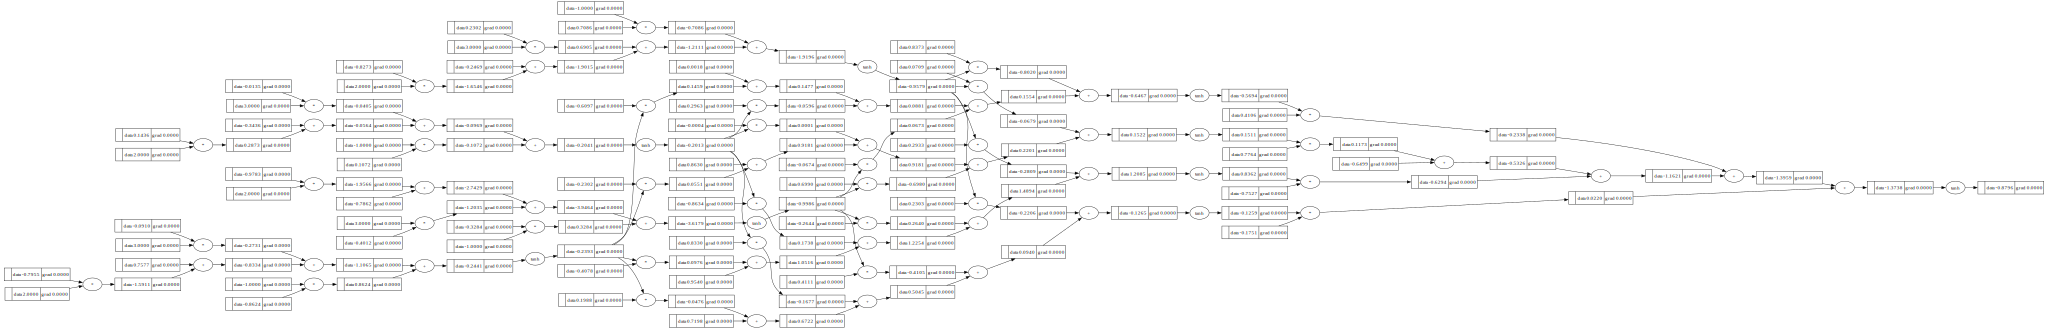

In [52]:
draw_dot(mlp(x))

## Training the MLP with a sample dataset

### Instantiate model 

In [290]:
mlp = MLP(3, [4, 4, 1])

### List model parameters

In [153]:
mlp.parameters()  # get all parameters of the MLP
# there are 41 parameters in total: 3*4 + 4*4 + 4*1 + 4 + 4 + 1 = 41

[Value(data=0.7416791972897097),
 Value(data=0.2394207370748307),
 Value(data=-0.5183404162873739),
 Value(data=0.8256580320471096),
 Value(data=-0.7137645597429807),
 Value(data=-0.07770017329000489),
 Value(data=-0.49204532117291544),
 Value(data=-0.4893465836816919),
 Value(data=-0.9812051370902579),
 Value(data=0.6092661539502926),
 Value(data=0.802418847197766),
 Value(data=0.3552217713981589),
 Value(data=-0.6840487558564261),
 Value(data=-0.11654043279237114),
 Value(data=-0.3088687511138366),
 Value(data=0.17514341025284286),
 Value(data=0.2778774047200243),
 Value(data=-0.15138212307820464),
 Value(data=-0.4998035511845975),
 Value(data=0.6906078502851973),
 Value(data=-0.6015660017822153),
 Value(data=-0.23061350206530906),
 Value(data=-0.0335838778815678),
 Value(data=-0.5255885961448508),
 Value(data=0.14384538470147779),
 Value(data=0.14962386035729014),
 Value(data=0.9853840872537951),
 Value(data=-0.4095384922334613),
 Value(data=0.9558889691537253),
 Value(data=0.316459

### Define dataset

In [291]:
xs = [
    [2.0,  3.0, -1.0],
    [3.0, -1.0,  0.5],
    [0.5,  1.0,  1.0],
    [1.0,  1.0, -1.0],
]

ys = [
     1.0,
    -1.0,
    -1.0,
     0.0
]  # labels for each input

### Make predictions and compute MSE

In [275]:
ypred = [mlp(x) for x in xs]  # forward pass. Naiive predictions
# print(ypred)

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print(loss)

Value(data=1.5278884568311164)


In [276]:
ypred

[Value(data=0.3181265078190382),
 Value(data=-0.7327138391272958),
 Value(data=-0.043015961129245786),
 Value(data=-0.27509390223086677)]

### Do backprop on loss once

In [277]:
for p in mlp.parameters():
    p.grad = 0.0  # reset gradients to zero
loss.backward()  # note that loss is connected to all the weights and biases in the network. 

In [278]:
print(mlp.layers[0].neurons[0].w[0].grad)  # check the gradient of the first weight in the first neuron
print(mlp.layers[0].neurons[0].w[0].data)

0.1815208242616389
-0.10053601096238358


### Run one step of optimisation

In [279]:
alpha = 0.01  # learning rate
for p in mlp.parameters():
    p.data += -alpha * p.grad  # update the parameters in the direction oppposite to the gradient to minimize the loss

## Create training loop

In [292]:
alpha = 0.05
for k in range(100):
    # forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    mlp.parameters()
    loss.backward()

    # update parameters
    for p in mlp.parameters():
        p.data += alpha * -p.grad 
        
    # zero gradients
    for p in mlp.parameters():
        p.grad = 0.0  # reset gradients to zero after each update
    
    print(k, loss.data)

0 1.7186849382682476
1 0.4790643180113448
2 0.28403565727281815
3 0.210765555445733
4 0.17023066209693483
5 0.1437112035926769
6 0.12448602733195875
7 0.10964283506476313
8 0.0977121409049665
9 0.08786141104071561
10 0.07957417955881914
11 0.07250605046362464
12 0.06641390250441151
13 0.06111836145004983
14 0.05648255260751829
15 0.052399332717902466
16 0.04878319027803015
17 0.045564852129907164
18 0.042687537362014326
19 0.0401042611463152
20 0.03777583674263142
21 0.03566935966077455
22 0.03375703586294792
23 0.032015262276349744
24 0.030423896556696407
25 0.02896567142013293
26 0.027625721053923663
27 0.026391195467412157
28 0.025250944528411194
29 0.02419525767787894
30 0.02321564844625887
31 0.02230467524200805
32 0.02145579166782907
33 0.020663220993663477
34 0.01992185048284393
35 0.019227142104100137
36 0.018575056822027987
37 0.01796199018259808
38 0.01738471732857597
39 0.01684034591533144
40 0.016326275667978063
41 0.015840163539683944
42 0.015379893608849319
43 0.014943550